In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
tracks = pd.read_csv('tracks_records.csv')
tracks.head()

,id,name,artists,id_artists,genres,release_year,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,35iwgR4jXetI318WEWsa1Q,Carve,Uli,['45tIt06XoI0Iio4LBEVpls'],NaN,1922,126.903,6,0.645,0.4450,0,46.662,1,0.4510,0.674,0.7440,0.151,0.127,104.851
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,Fernando Pessoa,['14jtPCOoNZwquk5wd9DxrY'],NaN,1922,98.200,0,0.695,0.2630,0,37.864,1,0.9570,0.797,0.0000,0.148,0.655,102.009
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],tango vintage tango,1922,181.640,0,0.434,0.1770,1,38.820,1,0.0512,0.994,0.0218,0.212,0.457,130.418
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],tango vintage tango,1922,176.907,0,0.321,0.0946,7,32.039,1,0.0504,0.995,0.9180,0.104,0.397,169.980
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,Dick Haymes,['3BiJGZsyX9sJchTqcSA7Su'],adult standards big band easy listening lounge...,1922,163.080,0,0.402,0.1580,3,43.100,0,0.0390,0.989,0.1300,0.311,0.196,103.220


In [3]:
tracks.info

<bound method DataFrame.info of                             id                                 name  \
0       35iwgR4jXetI318WEWsa1Q                                Carve   
1       021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista   
2       07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado   
3       08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado   
4       08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening   
...                        ...                                  ...   
586667  5rgu12WBIHQtvej2MdHSH0                                  云与海   
586668  0NuWgxEp51CutD2pJoF4OM                                blind   
586669  27Y1N4Q4U3EfDU5Ubw8ws2            What They'll Say About Us   
586670  45XJsGpFTyzbzeWK8VzR8S                      A Day At A Time   
586671  5Ocn6dZ3BJFPWh4ylwFXtn                     Mar de Emociones   

                          artists  \
0                             Uli   
1                 Fernando Pessoa   
2   

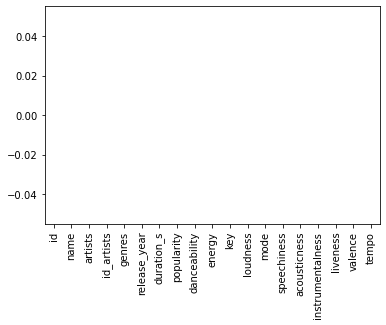

In [4]:
tracks.dropna(inplace = True)
tracks.isnull().sum().plot.bar()
plt.show()

In [5]:
tracks = tracks.drop(['id', 'id_artists'], axis = 1)

In [6]:
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(tracks.head(500))
plt.figure(figsize = (7, 7))
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.show()

ValueError: could not convert string to float: 'Vivo para Quererte - Remasterizado'

In [7]:
tracks['name'].nunique(), tracks.shape

(408902, (536847, 17))

In [8]:
tracks = tracks.sort_values(by=['popularity'], ascending=False)
tracks.drop_duplicates(subset=['name'], keep='first', inplace=True)

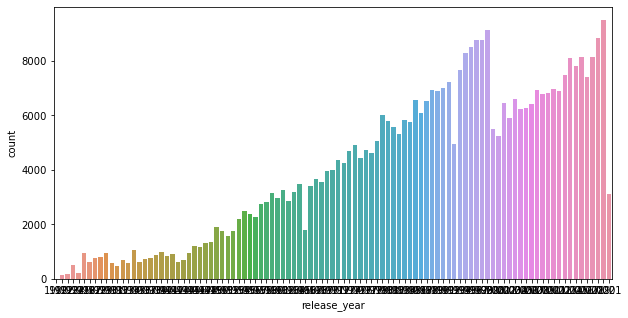

In [13]:
 plt.figure(figsize = (10, 5))
sb.countplot(tracks['release_year'])
plt.axis('on')
plt.show()

In [14]:
floats = []
for col in tracks.columns:
    if tracks[col].dtype == 'float':
        floats.append(col)
 
len(floats)

10

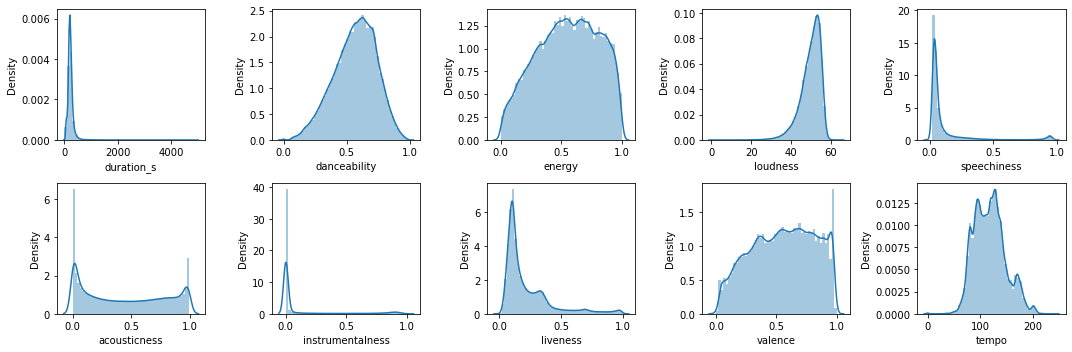

In [15]:
plt.subplots(figsize = (15, 5))
for i, col in enumerate(floats):
  plt.subplot(2, 5, i + 1)
  sb.distplot(tracks[col])
plt.tight_layout()
plt.show()

In [16]:
%%capture
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['genres'])

In [18]:
tracks = tracks.sort_values(by=['popularity'], ascending=False).head(10000)

In [24]:
def get_similarities(song_name, data):
   
  # get vector for the input song
  text_array1 = song_vectorizer.transform(data[data['name']==song_name]['genres']).toarray()
  num_array1 = data[data['name']==song_name].select_dtypes(include=np.number).to_numpy()
   
  # store similarity for each row of the dataset
  sim = []
  for idx, row in data.iterrows():
    name = row['name']
     
    # get vector for current song
    text_array2 = song_vectorizer.transform(data[data['name']==name]['genres']).toarray()
    num_array2 = data[data['name']==name].select_dtypes(include=np.number).to_numpy()
 
    # calculate similarities for text and numeric features
    text_sim = cosine_similarity(text_array1, text_array2)[0][0]
    num_sim = cosine_similarity(num_array1, num_array2)[0][0]
    sim.append(text_sim + num_sim)
     
  return sim

In [25]:
def recommend_songs(song_name, data=tracks):
  # Base case
  if tracks[tracks['name'] == song_name].shape[0] == 0:
        
    print('This song is either not so popular or you\
    have entered invalid_name.\n Some songs you may like:\n')
     
    for song in data.sample(n=5)['name'].values:
      print(song)
    return
   
  data['similarity_factor'] = get_similarities(song_name, data)
 
  data.sort_values(by=['similarity_factor', 'popularity'],
                   ascending = [False, False],
                   inplace=True)
   
  # First song will be highest similarity.
  display(data[['name', 'artists']][2:7])

In [21]:
recommend_songs('Shape of You')

,name,artists
90082,Supermarket Flowers,Ed Sheeran
91939,Bruises,Lewis Capaldi
91899,Before You Go,Lewis Capaldi
90741,What Do I Know?,Ed Sheeran
119306,Hearts Don't Break Around Here,Ed Sheeran


In [22]:
recommend_songs('Love me like you do')

This song is either not so popular or you    have entered invalid_name.
 Some songs you may like:

1985 - Intro to “The Fall Off”
Stand By You
Saturday Sun
Coffee & TV
HWAA


In [23]:
 recommend_songs('Lady of the Evening')

This song is either not so popular or you    have entered invalid_name.
 Some songs you may like:

I CAN'T STOP ME
Lonely Together (feat. Rita Ora)
gold rush
Without Me
Big Black Car
